# Document Clustering & similarity value prediction with Python

# Document duplicacy and similarity is an emerging issue which is the most efficient way to use storage efficiently. We can ignore duplicate documents and can increase our prosessing speed in a reasonable way.
Here in this example we have taken resume samples to identify which are simliar documents are their respective similarity ratio.


# Here we have performed following steps to our resume documents which are very large set of data:
1. tokenizing and stemming each synopsis
2. transforming the corpus into vector space using tf-idf
3. calculating cosine distance between each document as a measure of similarity
4. clustering the documents using the k-means algorithm
5. using multidimensional scaling to reduce dimensionality within the corpus
6. plotting the clustering output using matplotlib and mpld3
7. conducting a hierarchical clustering on the corpus using Ward clustering
8. plotting a Ward dendrogram
9. topic modeling using Latent Dirichlet Allocation (LDA)
10. similarity matrix with respect to a bunch of documents.


# Essential libraries listings

In [2]:

import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# Path setting

In [211]:
import os
listdir = []
path = 'D:/xray production/resume backup/Docs_Backup/Resume_set_01/train'

# List all Files

In [212]:
listdir = [os.path.join(dirpath, f)
for dirpath, dirnames, files in os.walk(path)
           for f in files if f.endswith('.txt')]

# Function to tokenize and stemming of raw data

In [182]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# NLTK reated libraries and stopwords updation

In [183]:
import logging
import os
import glob2
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import nltk
import re
import gensim
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}','%','&','+','$','@','~','-','_','://','--','[]']) # remove it if you need punctuation 
from nltk.tokenize import RegexpTokenizer
from datetime import datetime

In [184]:

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [185]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
synopses = []
totalvocab_stemmed = []
totalvocab_tokenized = []
for fle in listdir:
   # open the file and then call .read() to get the text 
   with open(fle, encoding="latin-1") as f:
        text = f.read()
        s = text
        synopses.append(s)

In [186]:
 for i in synopses:
            allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
            totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

            allwords_tokenized = tokenize_only(i)
            totalvocab_tokenized.extend(allwords_tokenized)

# Vocabulary data frame creation

In [187]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 248824 items in vocab_frame


# vocabs

In [188]:
print(vocab_frame.head())

                   words
applic         applicant
categori        category
profession  professional
requisit     requisition
code                code


# TF-IDF MATRIX & VECTOR CREATION 

In [189]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=100000, max_features=700000,
                                 min_df=0, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 9.56 s
(318, 259405)


In [190]:
terms = tfidf_vectorizer.get_feature_names()

# Cosine similarity matrix

In [191]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# k-means clustering algorithm

In [192]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 15.3 s


In [193]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [194]:
films = { 'title': listdir, 'synopsis': synopses, 'cluster': clusters }

frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster', 'synopsis'])

# Cluster and entitled values in each cluster

In [195]:
frame['cluster'].value_counts() 

3    79
2    66
4    61
1    57
0    55
Name: cluster, dtype: int64

# Cluster and corresponding words and titles

In [29]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'test', b'project', b'development', b'reports', b'oracle', b'used',

Cluster 0 titles: D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192752.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192820.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192822.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192830.txt,

C:\Users\amishra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':
C:\Users\amishra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


 D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192835.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192837.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192842.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192846.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192848.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192850.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192851.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192852.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192854.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192855.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192886.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192888.txt, D:/xray production/resume backup/Docs_Backup/Resume_set_01/train\192892.txt

# multidimentional scaling

In [30]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Giving cluster different colors and names

In [31]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [36]:
#set up cluster names using a dict
cluster_names = {0: 'first cluster', 
                 1: 'second cluster', 
                 2: 'third cluster', 
                 3: 'fourth cluster', 
                 4: 'fifth cluster'}

# clusters plot using matplotlib

C:\Users\amishra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


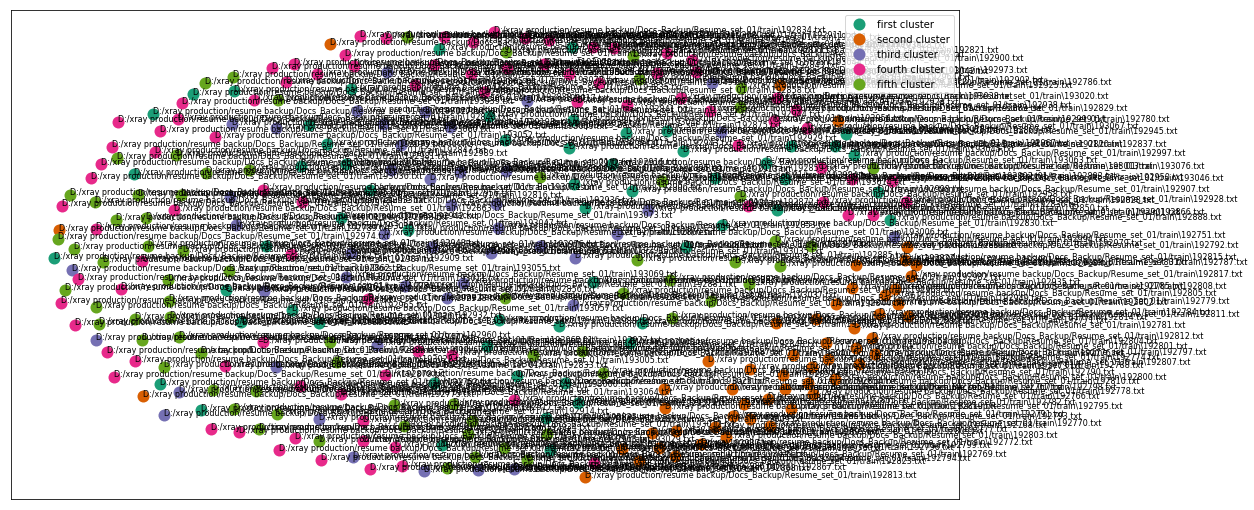

In [37]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=listdir)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

In [38]:
plt.close()

# Scatter plot of clusters with points showing references to the corresponding file names

In [39]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [112]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=listdir)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)

# Hierarchical document clustering

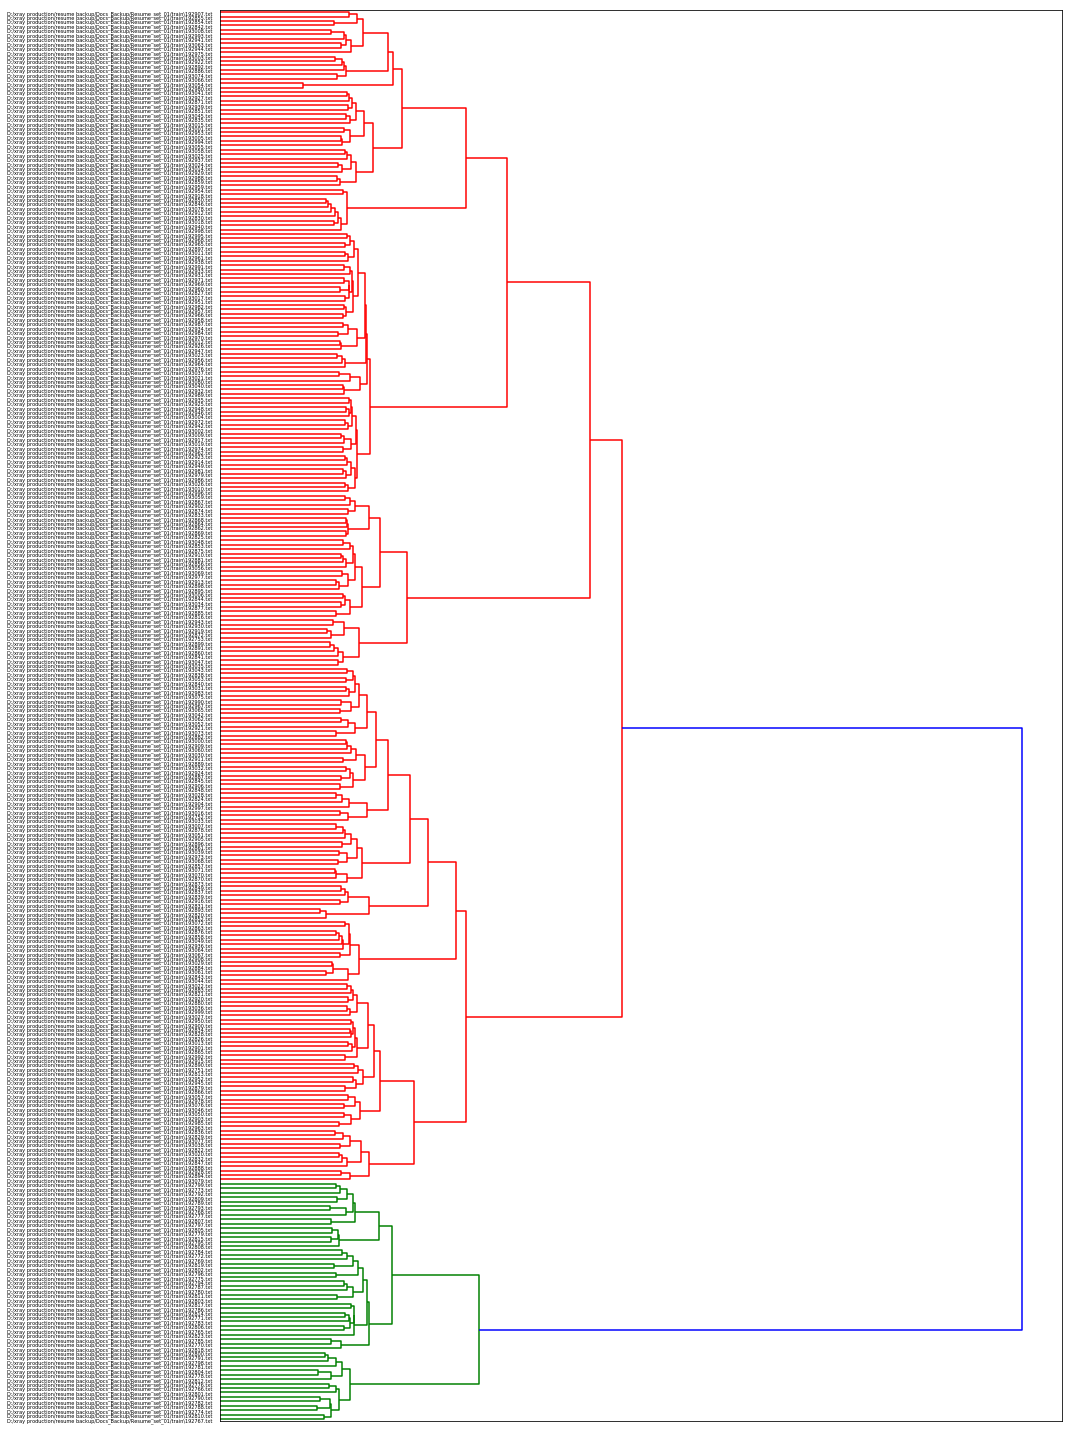

In [46]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=listdir);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [47]:
plt.close()

# Latent Dirichlet Allocation

In [48]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [49]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [51]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]


Wall time: 3.58 s
Wall time: 2.72 s


In [68]:
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')',
                   '[', ']', '{', '}','%','&','+','$','@','~','-','_','://','--','[]']) # remove it if you need punctuation 


In [69]:
#remove stop words
%time texts = [[word for word in text if word not in stop_words] for text in tokenized_text]

Wall time: 25 ms


In [70]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [74]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 4min 32s


In [76]:
lda.show_topics()

[(0,
  '0.014*"system" + 0.013*"month" + 0.013*"use" + 0.011*"specifi" + 0.010*"gmail.com" + 0.009*"test" + 0.009*"data" + 0.009*"work" + 0.009*"applic" + 0.009*"manag"'),
 (1,
  '0.021*"work" + 0.018*"specifi" + 0.011*"gmail.com" + 0.011*"project" + 0.009*"engin" + 0.009*"materi" + 0.007*"draw" + 0.006*"system" + 0.006*"per" + 0.006*"site"'),
 (2,
  '0.012*"experi" + 0.010*"militari" + 0.010*"equip" + 0.009*"level" + 0.009*"oper" + 0.008*"like" + 0.008*"search" + 0.008*"help" + 0.007*"question" + 0.007*"https"'),
 (3,
  '0.011*"work" + 0.006*"financi" + 0.005*"project" + 0.005*"account" + 0.005*"skill" + 0.005*"gmail.com" + 0.005*"perform" + 0.004*"train" + 0.004*"oper" + 0.004*"specifi"'),
 (4,
  '0.014*"manag" + 0.012*"team" + 0.011*"train" + 0.011*"product" + 0.010*"custom" + 0.009*"sale" + 0.009*"busi" + 0.008*"process" + 0.008*"month" + 0.008*"work"')]

In [111]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix,dtype=object)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

["('system', 0.013930067263968811)", "('month', 0.012975108381266243)", "('use', 0.012696189416809028)", "('specifi', 0.010734408675545164)", "('gmail.com', 0.0097738064518517551)", "('test', 0.0094430471895764635)", "('data', 0.0090699297840079497)", "('work', 0.0090291334880692464)", "('applic', 0.0087123249810280908)", "('manag', 0.0086790843163894668)", "('develop', 0.0085864569826078919)", "('support', 0.0084026275193507475)", "('project', 0.0083391632664919727)", "('network', 0.0081552516574210122)", '("\'s", 0.0074209337151694265)', "('server', 0.0070817186518829399)", "('user', 0.0069362805436867098)", "('team', 0.0061214123002106)", "('experi', 0.005985466848800935)", "('softwar', 0.0059212352661100328)"]

["('work', 0.020749515343922807)", "('specifi', 0.017795487007731838)", "('gmail.com', 0.01117747363893045)", "('project', 0.01052765394396204)", "('engin', 0.0091739740322179589)", "('materi', 0.0091465900454982627)", "('draw', 0.0074857332410223501)", "('system', 0.0060185

# test data prediction

In [202]:
import os
listdir = []
path = 'D:/xray production/resume backup/Docs_Backup/Resume_set_01/train'
listdir = [os.path.join(dirpath, f)
for dirpath, dirnames, files in os.walk(path)
           for f in files if f.endswith('.txt')]
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
synopses = []
totalvocab_stemmed = []
totalvocab_tokenized = []
for fle in listdir:
   # open the file and then call .read() to get the text 
   with open(fle, encoding="latin-1") as f:
        text = f.read()
        s = text
        synopses.append(s)
        
for i in synopses:
            allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
            totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

            allwords_tokenized = tokenize_only(i)
            totalvocab_tokenized.extend(allwords_tokenized)
            
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=100000, max_features=259405,
                                 min_df=0, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

there are 251352 items in vocab_frame
Wall time: 11.6 s
(335, 259405)


In [203]:
tfidf_matrix

<335x259405 sparse matrix of type '<class 'numpy.float64'>'
	with 435010 stored elements in Compressed Sparse Row format>

In [204]:
km.predict(tfidf_matrix)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3,

# Similarity matrix creation

In [213]:
# iterate over the list getting each file
vocab = []
dictionary = []
dic_tf = {}
dic_df = {}
for fle in listdir:
   # open the file and then call .read() to get the text 
   with open(fle, encoding="latin-1") as f:
        text = f.read()
        s = text
        text = ' '.join(w for w in re.split(r"\W", s) if w)  
        text = wordpunct_tokenize(text)
        for t in text:
            if t not in stop_words: 
                if not t.isdigit():
                    t=t.lower()
            if t.isdigit():
                text.remove(t)
        dictionary.append((text))

# Dicitonary creation

In [214]:
import gensim
dictio = gensim.corpora.Dictionary(dictionary)

In [215]:
corpus = [dictio.doc2bow(gen_doc) for gen_doc in dictionary]

In [216]:
tf_idf = gensim.models.TfidfModel(corpus)

In [219]:
sims = gensim.similarities.Similarity('D:/xray production/resume backup/Docs_Backup',tf_idf[corpus],
                                      num_features=len(dictio))

In [220]:
print(sims)
print(type(sims))

Similarity index with 318 documents in 0 shards (stored under D:/xray production/resume backup/Docs_Backup)
<class 'gensim.similarities.docsim.Similarity'>


# Test the similarity model

In [223]:
# iterate over the list getting each file
text = []
listdir = []
path = 'D:/xray production/resume backup/Docs_Backup/Resume_set_01/test'

listdir = [os.path.join(dirpath, f)
    for dirpath, dirnames, files in os.walk(path)
    for f in files if f.endswith('.txt')]
for fle in listdir:
   # open the file and then call .read() to get the text 
   with open(fle, encoding="latin-1") as f:
         text.append(f.read())
query_doc = []
from nltk.tokenize import RegexpTokenizer
for i in range(len(text)):
        s = text[i]
        text[i] = ' '.join(w for w in re.split(r"\W", s) if w)
for t in text:
    new_data = [i.lower() for i in wordpunct_tokenize(t) if i.lower() not in stop_words if not i.isdigit()]
    
    for n in new_data:
        if n.isdigit():
                new_data.remove(n)
        
    query_doc.append(new_data)

print(query_doc)

[['applicant', 'category', 'professional', 'requisition', 'code', 'two', 'initials', 'recruiter', 'lb', 'system', 'date', 'system', 'time', 'document', 'name', 'william', 'ward', 'ashmore', 'source', 'clearancejobs', 'com', 'resumes', 'searchterms', 'software', 'development', 'coding', 'test', 'researcher', 'build', 'user', 'interface', 'user', 'experience', 'url', 'http', 'www', 'clearancejobs', 'com', 'resumes', 'william', 'ward', 'ashmore', 'document', 'date', 'document', 'time', 'document', 'id', '42d62n82t', 'email', 'address', 'william', 'w', 'ashmore', 'gmail', 'com', 'location', 'al', 'start', 'resume', 'text', 'william', 'ward', 'ashmore', 'old', 'farm', 'lane', 'apt', 'e', 'prattville', 'alabama', 'date', 'added', 'contact', 'info', 'email', 'william', 'w', 'ashmore', 'gmail', 'com', 'mobile', 'security', 'clearance', 'clearance', 'status', 'active', 'security', 'clearance', 'clearance', 'level', 'secret', 'clearance', 'expiration', 'september', 'issuing', 'agency', 'dept', '

In [224]:
len(query_doc)

335

In [225]:
query_doc_bow = []
for doc in query_doc:
    query_doc_bow.append(dictio.doc2bow(doc))

In [226]:
len(query_doc_bow)

335

In [227]:
query_doc_tf_idf = []
for doc in query_doc_bow:
    query_doc_tf_idf.append(tf_idf[query_doc_bow])

In [229]:
len(query_doc_tf_idf)

335

In [230]:
query_doc_bow

[[(22, 5),
  (25, 3),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 4),
  (32, 1),
  (33, 7),
  (35, 1),
  (36, 1),
  (37, 2),
  (38, 2),
  (39, 8),
  (40, 3),
  (41, 8),
  (48, 4),
  (49, 3),
  (96, 1),
  (98, 1),
  (101, 1),
  (102, 1),
  (109, 1),
  (146, 1),
  (147, 1),
  (148, 1),
  (151, 1),
  (153, 2),
  (154, 1),
  (156, 1),
  (158, 1),
  (159, 1),
  (161, 3),
  (164, 1),
  (165, 1),
  (166, 1),
  (170, 2),
  (181, 65),
  (194, 1),
  (244, 1),
  (248, 1),
  (256, 7),
  (258, 1),
  (276, 4),
  (277, 3),
  (278, 5),
  (280, 2),
  (281, 1),
  (282, 1),
  (286, 1),
  (287, 1),
  (288, 2),
  (289, 2),
  (291, 3),
  (292, 3),
  (294, 1),
  (295, 4),
  (296, 1),
  (300, 4),
  (302, 1),
  (304, 1),
  (305, 11),
  (306, 1),
  (311, 1),
  (312, 7),
  (323, 1),
  (324, 1),
  (325, 8),
  (327, 1),
  (328, 2),
  (330, 1),
  (331, 1),
  (354, 2),
  (355, 3),
  (356, 2),
  (357, 2),
  (359, 1),
  (360, 1),
  (361, 1),
  (364, 2),
  (365, 1),
  (366, 1),
  (367, 1),
  (368, 1),

In [231]:
similarity = []
for doc in query_doc_tf_idf:
    similarity.append(sims[doc])

In [235]:
len(similarity)

335

# similarity Array

In [234]:
similarity[0][0]

array([ 0.35054645,  0.02322643,  0.08233488,  0.02395826,  0.00619038,
        0.00314484,  0.00269095,  0.03492863,  0.01003387,  0.0245425 ,
        0.02250338,  0.00713318,  0.00294751,  0.02309033,  0.0053916 ,
        0.00553387,  0.00711232,  0.00329042,  0.01363345,  0.00272545,
        0.02532524,  0.0557736 ,  0.0286211 ,  0.08015185,  0.02185713,
        0.01369142,  0.0042667 ,  0.00727741,  0.00391798,  0.00273466,
        0.00740061,  0.00467924,  0.01406436,  0.0072231 ,  0.02634818,
        0.01153965,  0.00308613,  0.02368234,  0.01297817,  0.01842993,
        0.03860107,  0.00693154,  0.0274331 ,  0.01729154,  0.03050437,
        0.01313151,  0.01739317,  0.00521036,  0.00947314,  0.00218326,
        0.00658219,  0.00834381,  0.02005658,  0.0217478 ,  0.01233016,
        0.02771564,  0.01719856,  0.10294344,  0.09369256,  0.02425669,
        0.08298051,  0.03256612,  0.01070248,  0.01108552,  0.02753989,
        0.10012275,  0.05605416,  0.11510827,  0.0232465 ,  0.09